# Proyecto final del curso de Data Science comision 23050

#### El dataset se obtuvo del siguiente link (https://www.kaggle.com/datasets/nehalbirla/vehicle-dataset-from-cardekho?ref=hackernoon.com&select=Car+details+v3.csv). 
### Objetivo a resolver:
#### Poder predecir el precio de un auto segun distintas variables que se obtienen

## Importacion de las librerias

In [1]:
# deshabilito los warnings
import warnings
warnings.filterwarnings('ignore')

#Datos
import pandas as pd
import numpy as np

# Visualizacion de Datos
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# esta línea se agrega para que imprima los gráficos dentro del notebook
%matplotlib inline  

from funpymodeling.exploratory import profiling_num
from funpymodeling.exploratory import freq_tbl

# modelos
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn import preprocessing 
from sklearn.model_selection import KFold
# metricas
from sklearn import model_selection, metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import math, time, random, datetime

## Data Acquisition

In [2]:
# Obtencion del Dataset

df = pd.read_csv("Car details v3.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## Data Wrangling

In [3]:
# Observo la dimension del df

df.shape

(8128, 13)

In [4]:
# veo la cantidad de valores vacios que hay.

df.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [5]:
# se decide eliminar los registros con valores vacios

df.dropna(inplace=True)

In [6]:
# observo nuevamente el tamaño sin los valores na
df.shape

(7906, 13)

In [7]:
# se comprueba que ya no quedan valores vacios en ningun registro

df.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [8]:
# veo los tipos de datos de cada variable. Observo que las variables mileage, engine y max_power son de tipo objeto ya que tienen el valor numero y el valor de medicion de ese dato.

df.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

In [9]:
# se procede a separar las variables mencionadas en el punto anterior para que se puedan trabajar como valores numericos.

mileage = df['mileage'].str.split(' ', expand=True)
engine = df['engine'].str.split(' ', expand=True)
max_power = df['max_power'].str.split(' ', expand=True)

In [10]:
# elimino las 3 columnas en cuestion para luego reemplazarlas por los valores que separe

df.drop(["mileage", "engine", "max_power"], inplace=True, axis=1)

In [11]:
# empiezo separando la varialbe mileage. Obtengo millas y la unidad de medida

df[["miles_per_liter","measure"]] = mileage

In [12]:
# observo que tengo 7819 registros como "kilometros por litro" y 87 en "kilometros por kilo". Para facilitar el analisis voy a eliminar los 87 registros que se midieron por kilo.
df["measure"].value_counts()

kmpl     7819
km/kg      87
Name: measure, dtype: int64

In [13]:
# me quedo solo con los que se midieron por litro

df = df[df["measure"] == "kmpl"]

In [14]:
# separo ahora los valores obtenidos de la variable engine

df[["engine_consumption","engine_measure"]] = engine

In [15]:
# observo que valores tengo en la columna "engine_measure". Me doy cuenta que solo tengo CC, asi que no hace falta hacer nada mas aca.

df["engine_measure"].value_counts()

CC    7819
Name: engine_measure, dtype: int64

In [16]:
# separo ahora los valores obtenidos de la variable max_power

df[["max_power","max_power_measure"]] = max_power

In [17]:
# observo que aca tambien solo tengo un valor de medida, asi que no hay que hacer nada mas.

df["max_power_measure"].value_counts()

bhp    7819
Name: max_power_measure, dtype: int64

In [18]:
# veo como tengo el df hasta el momento

df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,torque,seats,miles_per_liter,measure,engine_consumption,engine_measure,max_power,max_power_measure
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,190Nm@ 2000rpm,5.0,23.4,kmpl,1248,CC,74,bhp
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,250Nm@ 1500-2500rpm,5.0,21.14,kmpl,1498,CC,103.52,bhp
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,"12.7@ 2,700(kgm@ rpm)",5.0,17.7,kmpl,1497,CC,78,bhp
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,22.4 kgm at 1750-2750rpm,5.0,23.0,kmpl,1396,CC,90,bhp
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,"11.5@ 4,500(kgm@ rpm)",5.0,16.1,kmpl,1298,CC,88.2,bhp


In [19]:
# vuelvo a ver los tipos de datos y veo que, a pesar de haber convertido las columnas a variables con numeros, el tipo de dato sigue siendo "object"

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7819 entries, 0 to 8127
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                7819 non-null   object 
 1   year                7819 non-null   int64  
 2   selling_price       7819 non-null   int64  
 3   km_driven           7819 non-null   int64  
 4   fuel                7819 non-null   object 
 5   seller_type         7819 non-null   object 
 6   transmission        7819 non-null   object 
 7   owner               7819 non-null   object 
 8   torque              7819 non-null   object 
 9   seats               7819 non-null   float64
 10  miles_per_liter     7819 non-null   object 
 11  measure             7819 non-null   object 
 12  engine_consumption  7819 non-null   object 
 13  engine_measure      7819 non-null   object 
 14  max_power           7819 non-null   object 
 15  max_power_measure   7819 non-null   object 
dtypes: flo

In [20]:
# hago la conversion de las variables que me interesan a tipo de valor flotante

df[["miles_per_liter","engine_consumption","max_power"]]= df[["miles_per_liter","engine_consumption","max_power"]].astype("float")

In [21]:
# vuelvo a observar los tipos de datos, ahora si correctamente

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7819 entries, 0 to 8127
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   name                7819 non-null   object 
 1   year                7819 non-null   int64  
 2   selling_price       7819 non-null   int64  
 3   km_driven           7819 non-null   int64  
 4   fuel                7819 non-null   object 
 5   seller_type         7819 non-null   object 
 6   transmission        7819 non-null   object 
 7   owner               7819 non-null   object 
 8   torque              7819 non-null   object 
 9   seats               7819 non-null   float64
 10  miles_per_liter     7819 non-null   float64
 11  measure             7819 non-null   object 
 12  engine_consumption  7819 non-null   float64
 13  engine_measure      7819 non-null   object 
 14  max_power           7819 non-null   float64
 15  max_power_measure   7819 non-null   object 
dtypes: flo

In [22]:
# me quedo con las columnas que me va a interesar trabajar

df_reduced = df[["year","km_driven", "fuel", "seller_type", "transmission", "owner", "seats", "miles_per_liter", "engine_consumption", "max_power","selling_price"]]

In [23]:
# observo la informacion

df_reduced

,year,km_driven,fuel,seller_type,transmission,owner,seats,miles_per_liter,engine_consumption,max_power,selling_price
0,2014,145500,Diesel,Individual,Manual,First Owner,5.0,23.40,1248.0,74.00,450000
1,2014,120000,Diesel,Individual,Manual,Second Owner,5.0,21.14,1498.0,103.52,370000
2,2006,140000,Petrol,Individual,Manual,Third Owner,5.0,17.70,1497.0,78.00,158000
3,2010,127000,Diesel,Individual,Manual,First Owner,5.0,23.00,1396.0,90.00,225000
4,2007,120000,Petrol,Individual,Manual,First Owner,5.0,16.10,1298.0,88.20,130000
...,...,...,...,...,...,...,...,...,...,...,...
8123,2013,110000,Petrol,Individual,Manual,First Owner,5.0,18.50,1197.0,82.85,320000
8124,2007,119000,Diesel,Individual,Manual,Fourth & Above Owner,5.0,16.80,1493.0,110.00,135000
8125,2009,120000,Diesel,Individual,Manual,First Owner,5.0,19.30,1248.0,73.90,382000
8126,2013,25000,Diesel,Individual,Manual,First Owner,5.0,23.57,1396.0,70.00,290000


## EDA

### Graficos

#### Se observa la distribucion de las variables tipo de combustible, tipo de vendedor y tipo de transmision. 
#### Se ve que el 54% de los registros tienen tipo de combustible Diesel y el 46% Petrol
#### Se ve que el 83% de los autos corresponden a un tipo de vendedor individual, el 14% de tipo Dealer y el 3% a Trustmark Dealer
#### Se ve que el 86% de los autos corresponden a un tipo de transmision Manual y el 14% a automaticos

Text(0, 0.5, 'Cantidad')

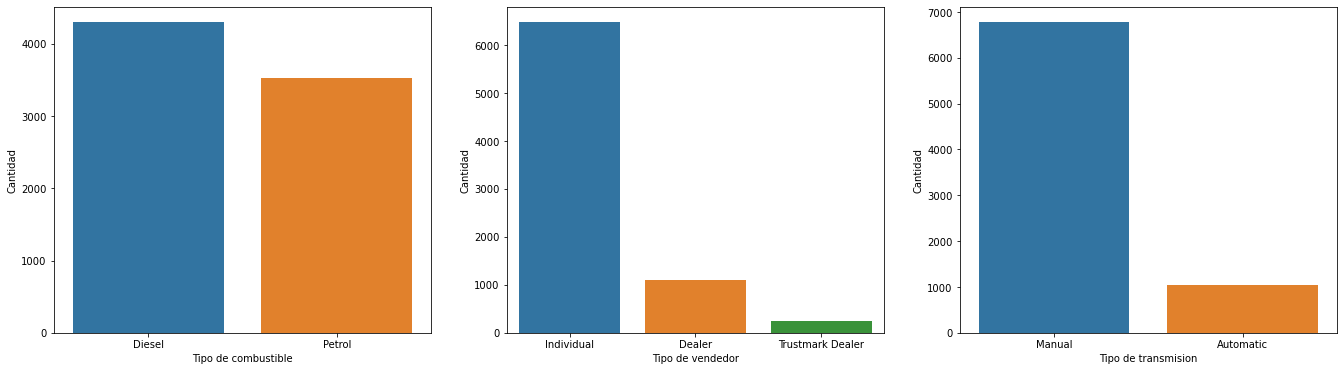

In [24]:
fig, axes = plt.subplots(1,3,figsize=(23,6))

plt.subplot(1,3,1)
sns.countplot(df_reduced["fuel"])
plt.xlabel("Tipo de combustible")
plt.ylabel("Cantidad")

plt.subplot(1,3,2)
sns.countplot(df_reduced["seller_type"])
plt.xlabel("Tipo de vendedor")
plt.ylabel("Cantidad")

plt.subplot(1,3,3)
sns.countplot(df_reduced["transmission"])
plt.xlabel("Tipo de transmision")
plt.ylabel("Cantidad")


#### Se observa la distribucion en porcentaje que tiene cada una de las variables

In [25]:
print("% combustible:")
print (df_reduced["fuel"].value_counts(normalize=True))
 
print ("---"*15)

print("% vendedor:")
print (df_reduced["seller_type"].value_counts(normalize=True))
print ("---"*15)

print("% transmision:")
print (df_reduced["transmission"].value_counts(normalize=True))

% combustible:
Diesel    0.549815
Petrol    0.450185
Name: fuel, dtype: float64
---------------------------------------------
% vendedor:
Individual          0.828367
Dealer              0.141450
Trustmark Dealer    0.030183
Name: seller_type, dtype: float64
---------------------------------------------
% transmision:
Manual       0.866863
Automatic    0.133137
Name: transmission, dtype: float64


#### Se observa la distribucion de la variable "owner"
#### Se observa que la mayoria de los autos han tenido solo un dueño y que vemos unos pocos autos que corresponden a autos concept de prueba

Text(0, 0.5, 'Cantidad')

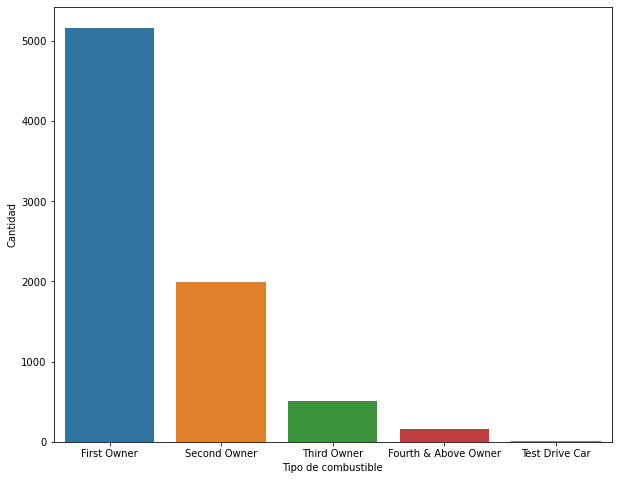

In [26]:
plt.figure(figsize=(10,8))
sns.countplot(df_reduced["owner"])
plt.xlabel("Tipo de combustible")
plt.ylabel("Cantidad")

#### Se realiza un histograma de las variables numericas. Se observa lo siguiente:
#### Kilometros recorridos: tiene una distribucion normal acostada sobre la cola derecha.
#### Millas por litro: tiene una distribucion normal
#### Engine Consumption: no tiene distribucion normal
#### Max_power: no tiene distribucion normal

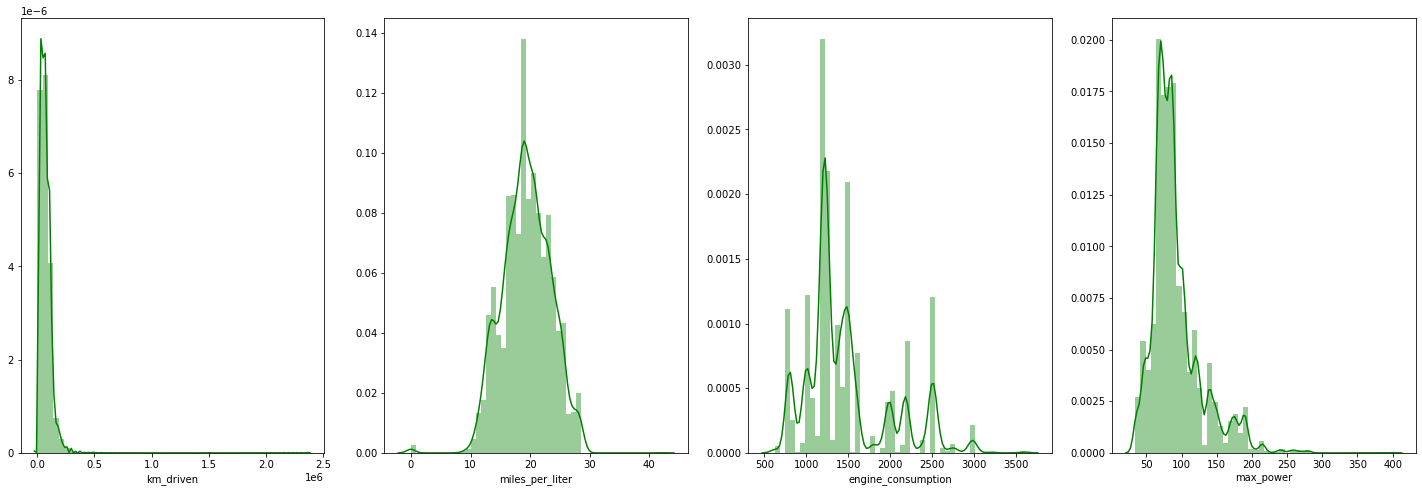

In [27]:
fig, axes = plt.subplots(1,4,figsize=(25,8))

sns.distplot(df_reduced["km_driven"], hist=True, kde=True, color="g",ax=axes[0] )

sns.distplot(df_reduced["miles_per_liter"], hist=True, kde=True, color="g", ax=axes[1])

sns.distplot(df_reduced["engine_consumption"], hist=True, kde=True, color="g", ax=axes[2])

sns.distplot(df_reduced["max_power"], hist=True, kde=True, color="g", ax=axes[3])

plt.show()

#### Se realiza un analisis con Boxplots. Se observa que todas las variables numericas tienen valores anomalos que deberan ser tratados para evitar distorciones en el modelo

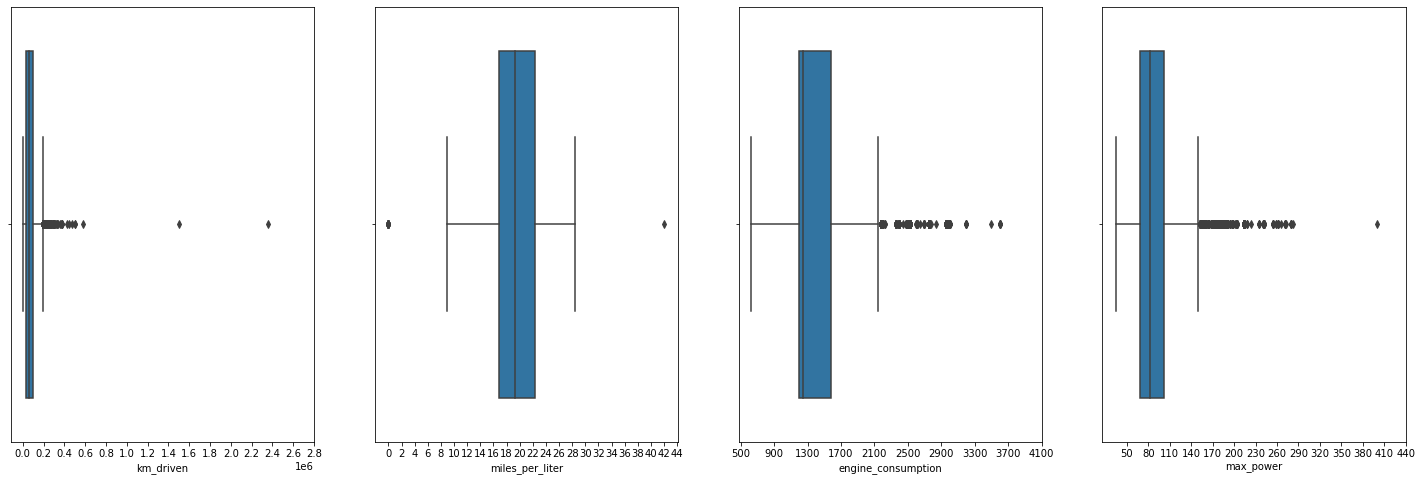

In [28]:
# boxplot
# aclaracion: el eje x de la figura "km_driven" esta en formato cientifico ya que hay valores muy grandes. Para obtener los valores reales se debe multiplicar por 1000000

fig, axes = plt.subplots(1,4,figsize=(25,8))

plt.subplot(1,4,1)
sns.boxplot(df_reduced["km_driven"])
plt.xticks(np.arange(0,3000000,200000))

plt.subplot(1,4,2)
sns.boxplot(df_reduced["miles_per_liter"])
plt.xticks(np.arange(0,45,2))

plt.subplot(1,4,3)
sns.boxplot(df_reduced["engine_consumption"])
plt.xticks(np.arange(500,4500,400))

plt.subplot(1,4,4)
sns.boxplot(df_reduced["max_power"])
plt.xticks(np.arange(50,450,30))

plt.show()

#### Se realiza un analisis por separado la variable target: "selling price". Observo que despues de los $180.000 (aprox), empiezan los valores extremos.

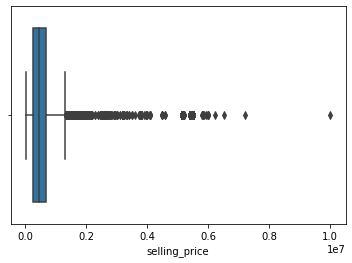

In [29]:
sns.boxplot(df_reduced["selling_price"])
plt.show()

#### Analizo la relacion entre los kilometros recorridos y la variable tipo de combustible. Se observa que los autos con combustible diesel tienen valores mas altos que los que tienen Petrol

<AxesSubplot:xlabel='fuel', ylabel='selling_price'>

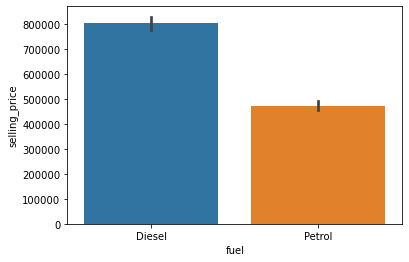

In [30]:
sns.barplot(x= df_reduced["fuel"], y = df_reduced["selling_price"])

#### Analizo la variable tipo de dueño. Observo que hay unos pocos autos de prueba con precios muy altos

Text(0.5, 0, 'Dueño')

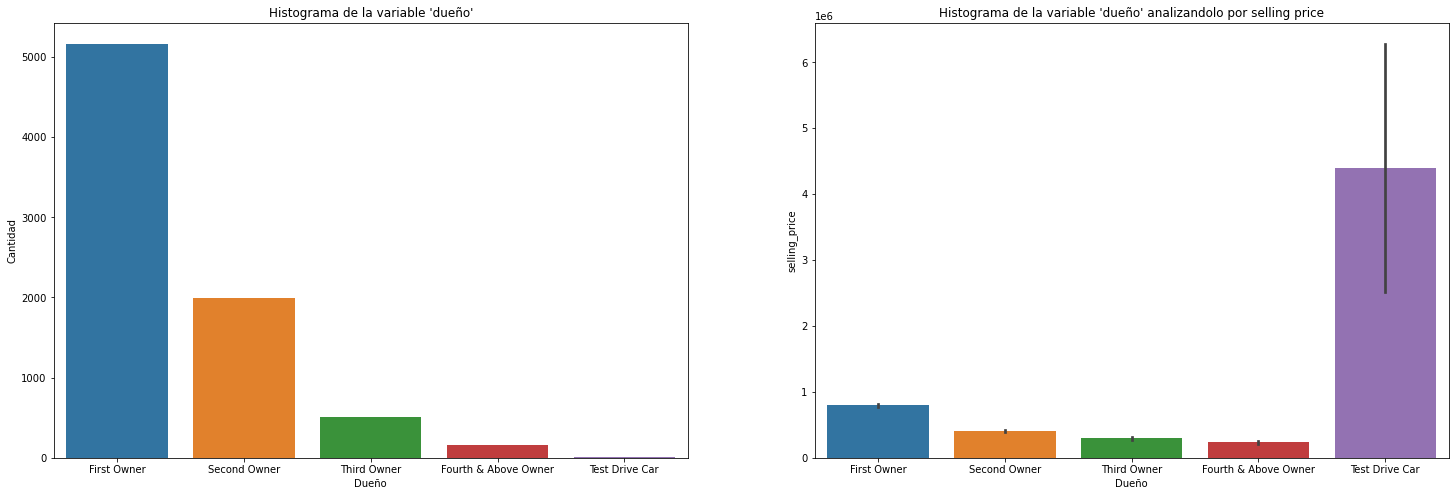

In [31]:
fig, axes = plt.subplots(1,2,figsize=(25,8))

plt.subplot(1,2,1)
sns.countplot(df_reduced["owner"])
plt.title("Histograma de la variable 'dueño'")
plt.xlabel("Dueño")
plt.ylabel("Cantidad")

plt.subplot(1,2,2)
sns.barplot(x= df_reduced["owner"], y = df_reduced["selling_price"])
plt.title("Histograma de la variable 'dueño' analizandolo por selling price")
plt.xlabel("Dueño")

#### Observo que hay 5 autos de prueba que tienen valores muy altos por lo que debo eliminarlos para no distorcionar el analisis


In [32]:
df_reduced["owner"].value_counts()

First Owner             5165
Second Owner            1988
Third Owner              503
Fourth & Above Owner     158
Test Drive Car             5
Name: owner, dtype: int64

#### Observo la correlacion entre las variables numericas. Se observa que el precio de venta tiene su mayor correlacion con el poder maximo del auto. 

<AxesSubplot:>

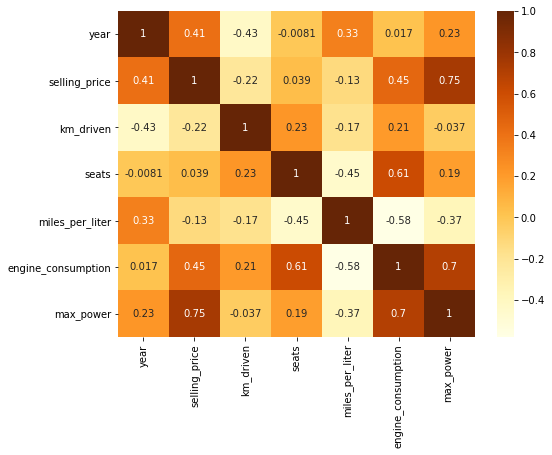

In [33]:
plt.subplots(figsize=(8,6))
sns.heatmap(df.corr(), annot=True,cmap="YlOrBr")

#### Vuelvo a ver esa relacion entre las variables. Se vuelven a observar los valores extremos ya vistos en el boxplot.

<AxesSubplot:xlabel='selling_price', ylabel='max_power'>

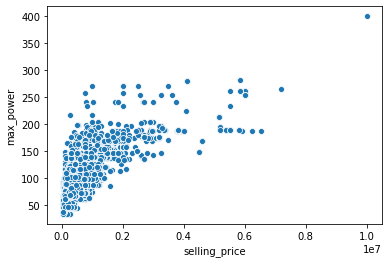

In [34]:
sns.scatterplot(df_reduced["selling_price"],df["max_power"])

#### Observo lo mismo que en el grafico anterior pero segmentandolo tambien por el tipo de combustible

<AxesSubplot:xlabel='selling_price', ylabel='max_power'>

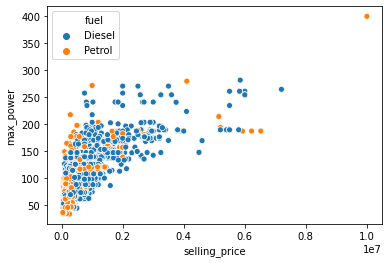

In [35]:
sns.scatterplot(df_reduced["selling_price"],df["max_power"], hue= df["fuel"])

### Eliminacion de valores outliers

In [36]:
# defino una funcion para obtener una lista con outliers

def outliers(df,ft):
    q1 = df[ft].quantile(0.25)
    q3 = df[ft].quantile(0.75)
    IQR = q3 - q1
    
    lower_bound = q1 - 1.5 * IQR
    upper_bound = q3 + 1.5 * IQR
    
    ls = df.index[ (df[ft] < lower_bound) | (df[ft] > upper_bound)]
    return ls

In [37]:
# creo una lista para acumular los outliers de diferentes columnas. Solo lo voy a hacer para las variables que voy a analizar.

index_list = []

for feature in ["engine_consumption",  "max_power","selling_price" ]:
    index_list.extend(outliers(df_reduced,feature))

In [38]:
# creo una funcion para eliminar los outliers y quedarme con el dataframe final

def remove (df,ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df

In [39]:
# creo el dataset final, filtrando del dataset que tenia, la lista con los outliers

df_cleaned = remove(df_reduced, index_list)

In [40]:
print ("Se han eliminado", df_reduced.shape[0] - df_cleaned.shape[0], " variables")

Se han eliminado 1570  variables


#### Observo nuevamente los valores anomalos. Observo que todavia quedan algunos

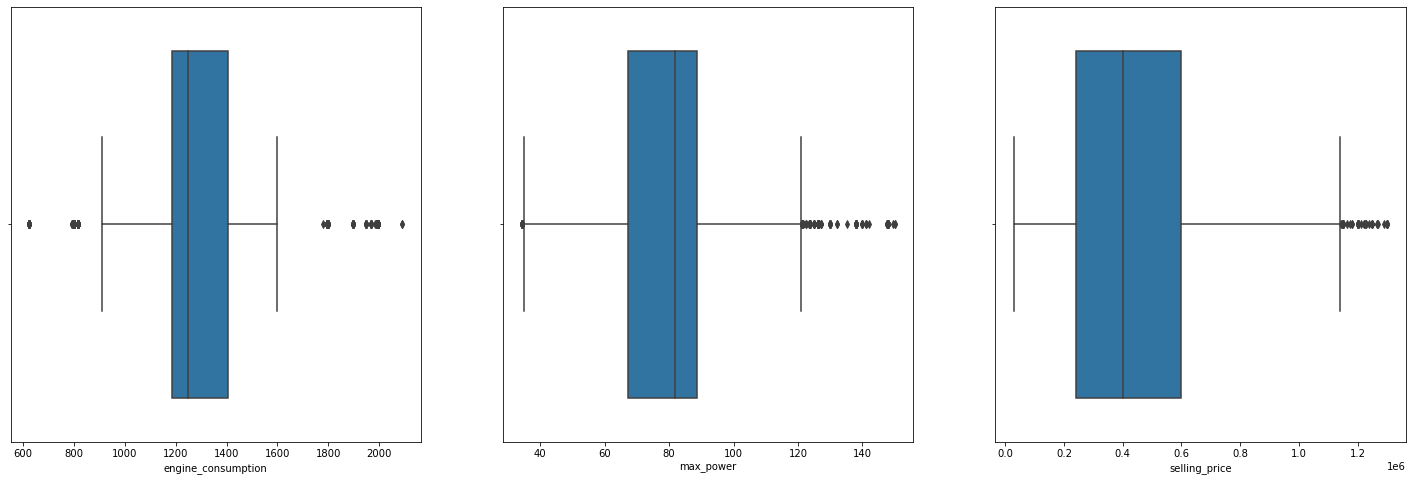

In [41]:
fig, axes = plt.subplots(1,3,figsize=(25,8))


plt.subplot(1,3,1)
sns.boxplot(df_cleaned["engine_consumption"])

plt.subplot(1,3,2)
sns.boxplot(df_cleaned["max_power"])

plt.subplot(1,3,3)
sns.boxplot(df_cleaned["selling_price"])


plt.show()

## Etapa de eleccion del modelo de prediccion

#### Se trabajara con la variable target "selling_price". Las variables predictoras seran "max_power", "year". En una primera instancia iba a trabajar tambien con la variable engine_consumption como predictora pero al observar que entre max_power y engine consumption a su vez hay correlacion, se decidio no incluir engine_consumption para no distorcionar el analisis. De esas 2, max_power es la de mayor correlacion con la variable target por eso elegi quedarme con esa y con year.

#### Definicion de las variables independientes y de la variable dependiente

In [42]:
x = df_cleaned[["year", "max_power"]]
y = df_cleaned["selling_price"]

#### Separacion de los datos en datos de entrenamiento y de prueba

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=1)

#### Definicion de funcion para ejecutar los modelos

In [44]:
def fit_ml_algo(algo, train_x , train_y , test_x, test_y):
    
    model = algo.fit(train_x, train_y)
    y_pred = algo.predict(test_x)
    score = round(r2_score(test_y, y_pred) * 100, 2)
    mse = mean_squared_error(test_y , y_pred , squared=False)
    mae = mean_absolute_error(test_y, y_pred)
    
    
    return model, score, mse, mae

### Regresion Linear

In [45]:
start_time = time.time()
modelo, score, mse, mae = fit_ml_algo(linear_model.LinearRegression(), x_train, y_train, x_test, y_test)

log_time = (time.time() - start_time)

print("R2 Score: %s" % score)
print("Error cuadratico medio: %s" % mse)
print("Error absoluto medio: %s" % mae)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

R2 Score: 68.76
Error cuadratico medio: 130706.97057171627
Error absoluto medio: 102219.29610009721
Running Time: 0:00:00.045103


### Arbol de decision

In [46]:
start_time = time.time()
modelo, score, mse, mae = fit_ml_algo(tree.DecisionTreeClassifier(criterion="entropy", max_depth=3), x_train, y_train, x_test, y_test)

log_time = (time.time() - start_time)

print("R2 Score: %s" % score)
print("Error cuadratico medio: %s" % mse)
print("Error absoluto medio: %s" % mae)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

R2 Score: 68.38
Error cuadratico medio: 131499.72863214425
Error absoluto medio: 94967.5585412668
Running Time: 0:00:00.036592


#### Grafico el arbol

In [47]:
print(tree.export_text(modelo,
                      feature_names=["year", "max_power"]))

|--- year <= 2013.50
|   |--- max_power <= 73.40
|   |   |--- year <= 2009.50
|   |   |   |--- class: 120000
|   |   |--- year >  2009.50
|   |   |   |--- class: 200000
|   |--- max_power >  73.40
|   |   |--- year <= 2011.50
|   |   |   |--- class: 250000
|   |   |--- year >  2011.50
|   |   |   |--- class: 350000
|--- year >  2013.50
|   |--- max_power <= 73.96
|   |   |--- max_power <= 62.60
|   |   |   |--- class: 250000
|   |   |--- max_power >  62.60
|   |   |   |--- class: 350000
|   |--- max_power >  73.96
|   |   |--- max_power <= 87.00
|   |   |   |--- class: 600000
|   |   |--- max_power >  87.00
|   |   |   |--- class: 650000



### Random Forest

In [48]:
start_time = time.time()
modelo, score, mse, mae = fit_ml_algo(RandomForestRegressor(n_estimators=100, 
                               max_features="sqrt",
                               bootstrap=True,
                               max_samples=2/3,
                               oob_score=True), x_train, y_train, x_test, y_test)

log_time = (time.time() - start_time)

print("R2 Score: %s" % score)
print("Error cuadratico medio: %s" % mse)
print("Error absoluto medio: %s" % mae)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

R2 Score: 86.58
Error cuadratico medio: 85658.76041343964
Error absoluto medio: 60856.26527092076
Running Time: 0:00:00.676626


### KNN

#### Escalado de las variables

In [49]:
from sklearn import preprocessing 
escala_x = preprocessing.MinMaxScaler()
escala_y = preprocessing.MinMaxScaler()

x_train_escalado = escala_x.fit_transform(x_train)
y_train_escalado = escala_y.fit_transform(y_train.values.reshape(-1,1))
x_test_escalado = escala_x.fit_transform(x_test)
y_test_escalado = escala_y.fit_transform(y_test.values.reshape(-1,1))

In [50]:
start_time = time.time()
modelo, score, mse, mae = fit_ml_algo(KNeighborsRegressor(n_neighbors=3),x_train_escalado, y_train_escalado, x_test_escalado, y_test_escalado)

log_time = (time.time() - start_time)

print("R2 Score: %s" % score)
print("Error cuadratico medio: %s" % mse)
print("Error absoluto medio: %s" % mae)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

R2 Score: 69.55
Error cuadratico medio: 0.101611936729374
Error absoluto medio: 0.07456947092431046
Running Time: 0:00:00.021387


## Analisis con GridSearchCV

#### Defino el diccionario para luego analizar los distintos modelos y los distintos hiperparametros

In [51]:
model_params = {
    'linear_regression':{
        'model':linear_model.LinearRegression(),
        'params':{}
    },
    
    'random_forest':{
        'model':RandomForestRegressor(max_features="sqrt",
                               bootstrap=True,
                               max_samples=2/3,
                               oob_score=True),
        'params':{
            'n_estimators':[100,125,150],
            'criterion':['squared_error','absolute_error', 'poisson']
        }
    },
    'knn':{
        'model':KNeighborsRegressor(),
        'params':{
            'n_neighbors':np.arange(3,8,1)
        }
    }
}

#### Hago un for para hacer la comparacion

In [52]:
from sklearn.model_selection import GridSearchCV

scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp['model'], mp['params'],return_train_score=False, cv=KFold(5, random_state=2,shuffle=True ))
    if mp['model'] == KNeighborsRegressor():
        clf.fit(x_train_escalado, y_train_escalado)
    else:
        clf.fit(x_train,y_train)
    scores.append({
        'model':model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })


In [53]:
model_params.items()

dict_items([('linear_regression', {'model': LinearRegression(), 'params': {}}), ('random_forest', {'model': RandomForestRegressor(max_features='sqrt', max_samples=0.6666666666666666,
                      oob_score=True), 'params': {'n_estimators': [100, 125, 150], 'criterion': ['squared_error', 'absolute_error', 'poisson']}}), ('knn', {'model': KNeighborsRegressor(), 'params': {'n_neighbors': array([3, 4, 5, 6, 7])}})])

#### Imprimo los resultados: el mejor modelo es el de Random Forest con cirterio de squared_error y n_estimators=125

In [54]:
scores 

[{'model': 'linear_regression',
  'best_score': 0.6811637865989629,
  'best_params': {}},
 {'model': 'random_forest',
  'best_score': 0.8716817302008391,
  'best_params': {'criterion': 'squared_error', 'n_estimators': 125}},
 {'model': 'knn',
  'best_score': 0.8569903698819002,
  'best_params': {'n_neighbors': 6}}]

In [55]:
df_scores = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
df_scores

,model,best_score,best_params
0,linear_regression,0.681164,{}
1,random_forest,0.871682,"{'criterion': 'squared_error', 'n_estimators':..."
2,knn,0.856990,{'n_neighbors': 6}


## Conclusiones

### Se decidio en primera instancia analizar 4 modelos con distintos resultados cada uno:
-  #### Regresion lineal dio un R2 de 0.687
-  #### Arbol de decision dio un R2 de 0.683
-  #### Random Forest dio un R2 de 0.866
-  #### KNN dio un R2 de 69.55

### De esto se puede concluir que el Random Forest es el mejor de estos modelos.

### Luego, se decidio analizar los modelos de regresion linear, random forest y knn teniendo en cuenta distintos parametros de cada uno de los modelos para ver comparativamente cual era el mejor y cual era la mejor combinacion de parametros
### Los distintos parametros que se analizaron fueron: 
-  #### Random Forest: n_estimators:100,125 y 150. Criterion:'squared_error','absolute_error', 'poisson'
-  #### KNN: n_neighbors: 3,4,5,6,7

### Se concluyo que el mejor modelo era el Random Forest con 125 arboles y el criterio squared_error. Su R2 fue 0.87179
### Tambien, se observo que el modelo knn mejora mucho con n_neighbors=6